In [1]:
from main import *

In [20]:
path = "/data1/users/marshall/prod-ref/v06.00/"
pn.extension()

In [3]:
pars = detailed_cal_params(path=path)
buttons = pn.Param(pars.param, widgets={
    'run': {'widget_type': pn.widgets.Select, 'width':150},
    'channel': {'widget_type': pn.widgets.Select, 'width':150},
    'parameter': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width':150},
    'plot_type': {'widget_type': pn.widgets.RadioButtonGroup, 'button_type': 'success', 
                'orientation':"vertical", 'width':150}}
)

cal = cal_summary(path=path)
cal_buttons = pn.Param(cal.param, widgets={
    'run': {'widget_type': pn.widgets.Select, 'width':150},
    'sort_by': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width':150},
    'plot_type': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width':150},
    'string': {'widget_type': pn.widgets.RadioButtonGroup, 'button_type': 'success', 
                'orientation':"vertical", 'width':150}}
)


ct = cal_tracking(path=path)
ct_buttons = pn.Param(ct.param, widgets={
    'date_range': {'widget_type': pn.widgets.DateRangeSlider, 'width':150},
    'plot_type': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width':150},
    'sort_by': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width':150},
    'string': {'widget_type': pn.widgets.RadioButtonGroup, 'button_type': 'success', 
                'orientation':"vertical", 'width':150}}
)

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Param(cal_summary, widgets={'run': {'widget_type': <c...})
            [1] ParamMethod(method)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Param(cal_tracking, widgets={'date_range': {'widget_ty...})
            [1] ParamMethod(method)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] Param(detailed_cal_params, widgets={'run': {'widget_type': <c...})
            [1] ParamMethod(method)
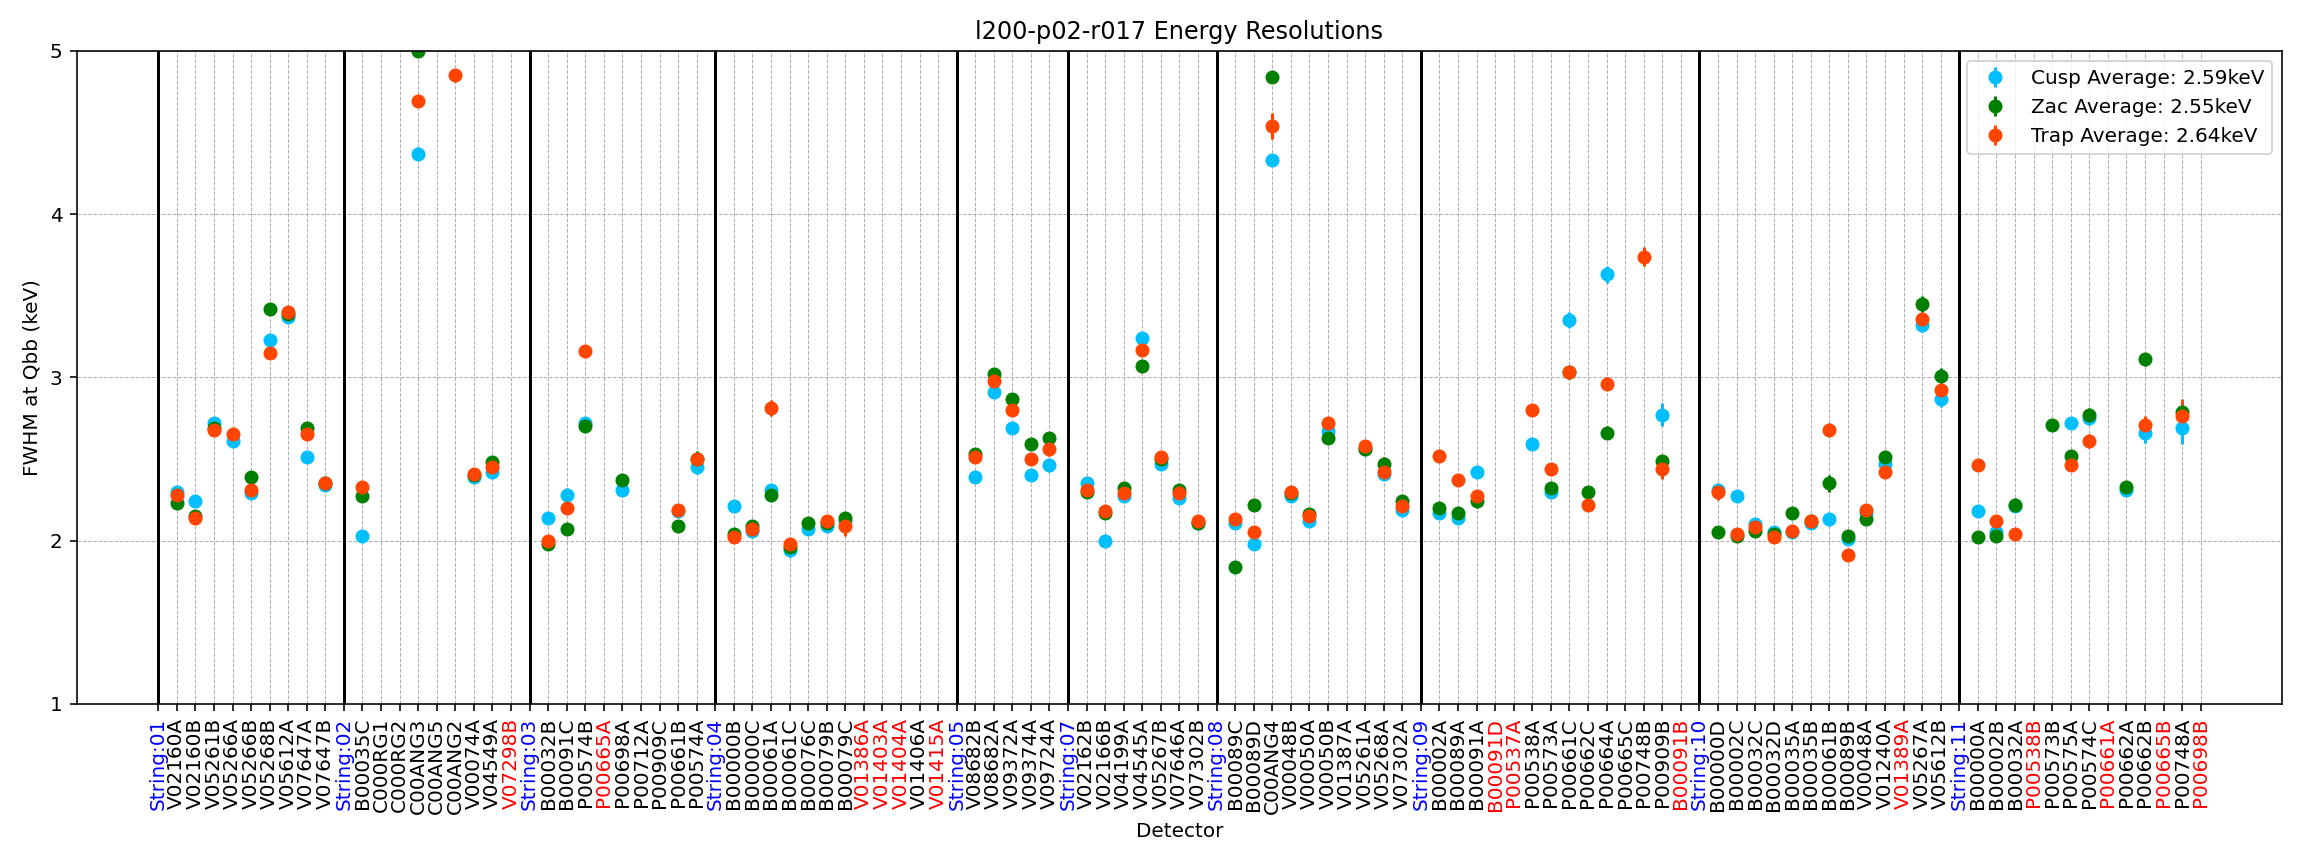
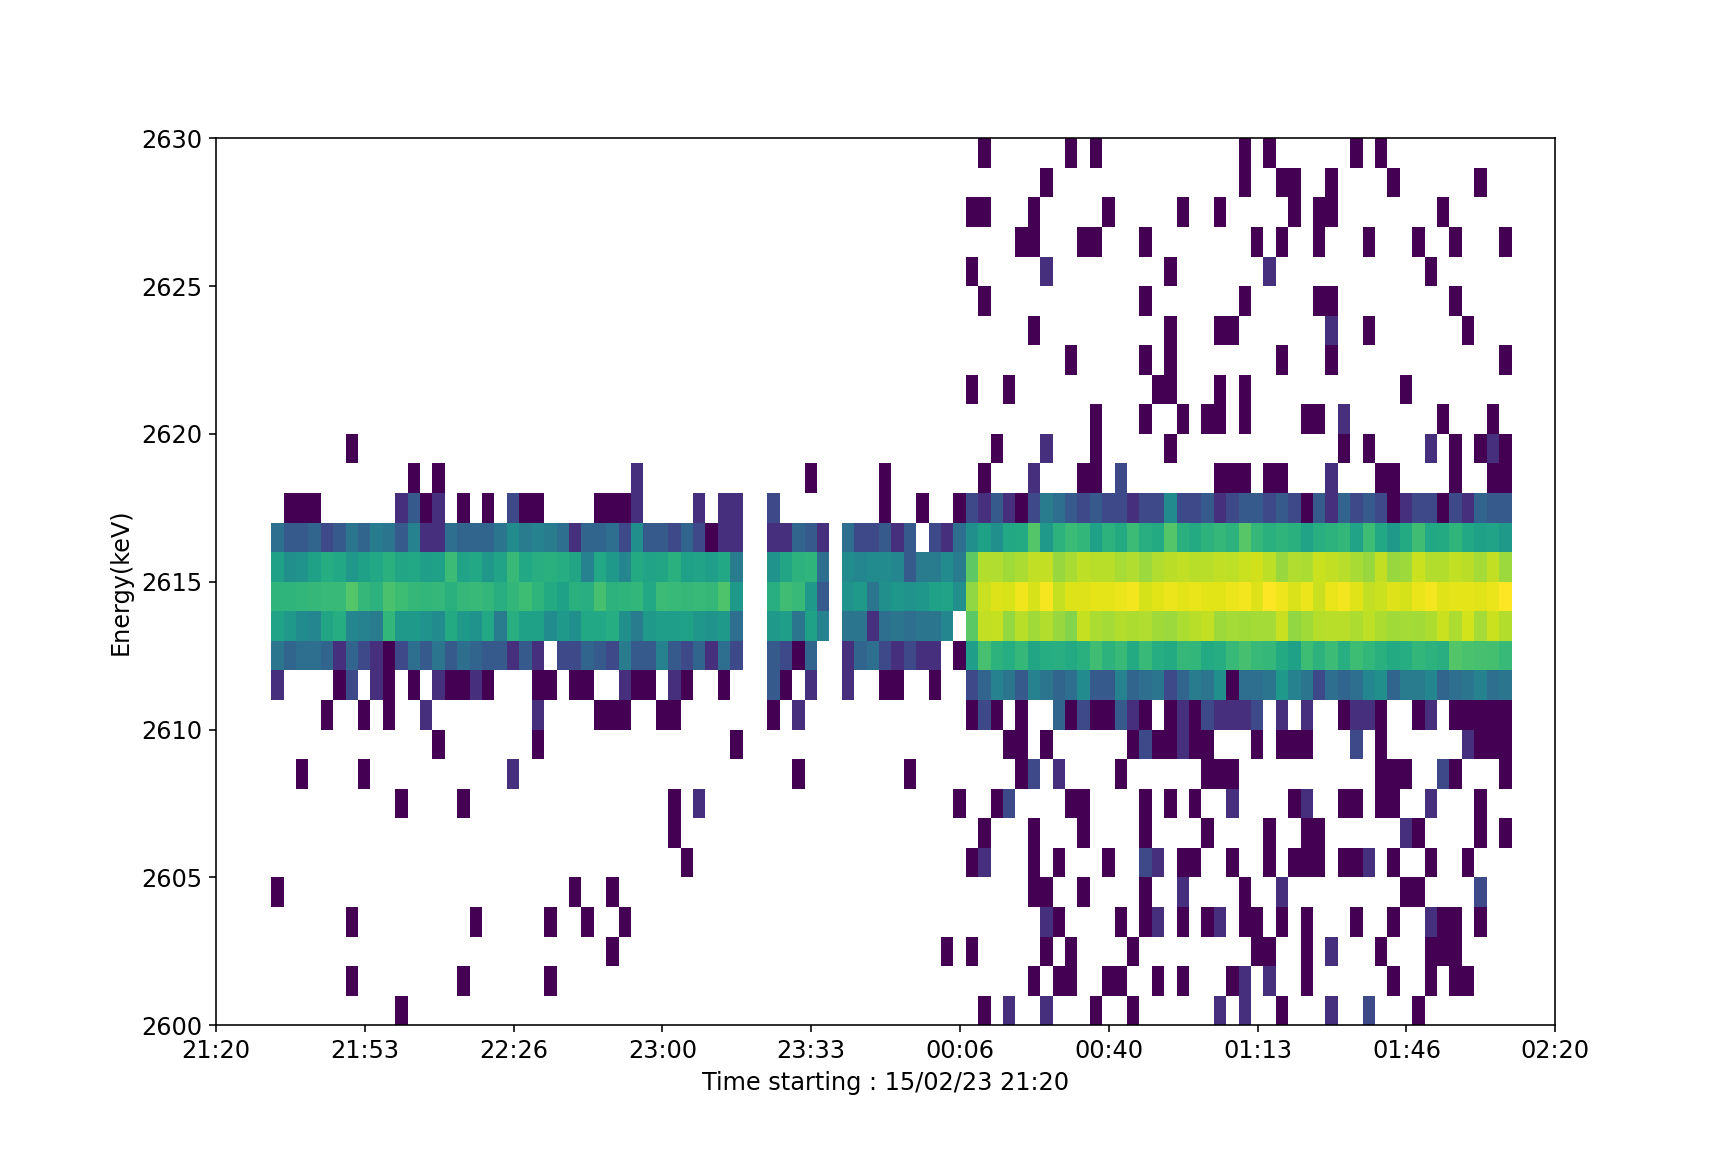

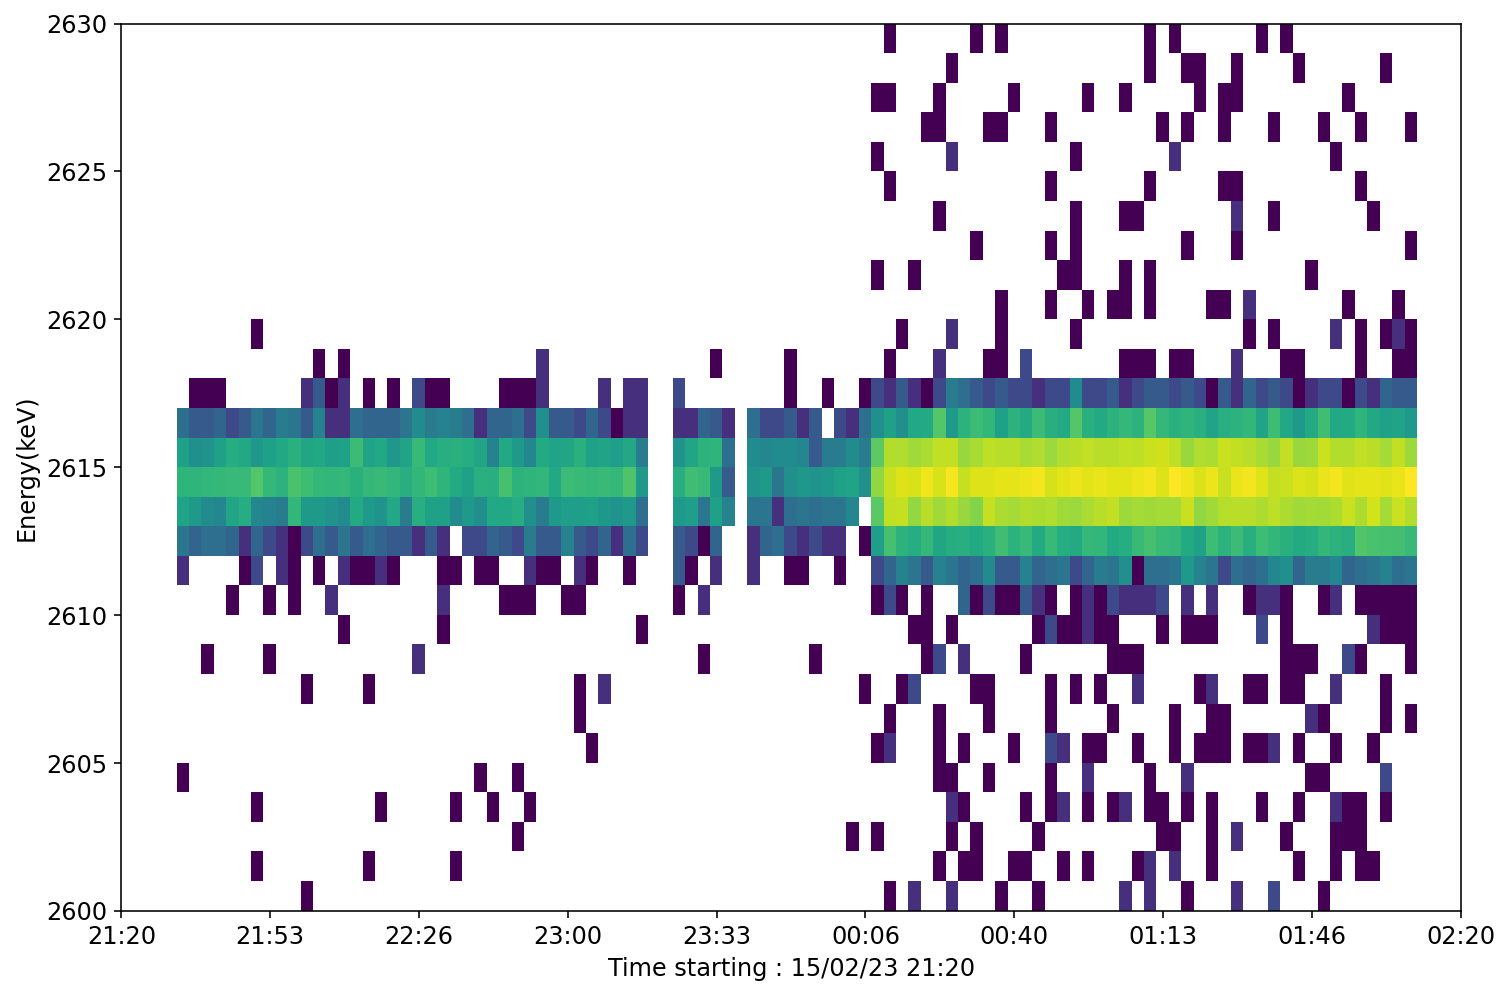

In [4]:
pn.Tabs(("Cal Summary", pn.Column("# Summary Cal Plots", 
      pn.Row(
             cal_buttons, 
          cal.view)
     ))
     , 
   ("Cal Tracking" , pn.Column("# Cal Tracking", 
      pn.Row(
             ct_buttons, 
          ct.view)
     )),

    ("Detailed_cal_plots",pn.Column("# Detailed Calibration Plots", 
      pn.Row(
             buttons, 
          pars.view)
     )
    )
   )

In [33]:
class monitoring(param.Parameterized):
    
    plt.rcParams['font.size'] = 10
    plt.rcParams['figure.figsize'] = (16, 6)
    plt.rcParams['figure.dpi'] = 100
    
    
    cal_plots = ['cal_stability', 'peak_fits', 'cal_fit', 'fwhm_fit', 'spectrum_plot', 'survival_frac', "spectrum", "logged_spectrum"]
    aoe_plots = ['dt_deps', 'compt_bands_nocorr', 'band_fits', 'mean_fit', 'sigma_fit', 'compt_bands_corr', 'surv_fracs', 'PSD_spectrum', 'psd_sf']
    tau_plots =["slope", "waveforms"]
    optimisation_plots = ["trap_kernel", "zac_kernel", "cusp_kernel", "trap_acq", "zac_acq", "cusp_acq"]
    
    _options = {'cuspEmax_ctc': cal_plots , 'zacEmax_ctc': cal_plots,
            'trapEmax_ctc': cal_plots , 'trapTmax': cal_plots,
            "A/E": aoe_plots, "Tau": tau_plots, "Optimisation": optimisation_plots}
        
    plot_types_summary_dict = {"Energy Qbb": plot_energy_resolutions_Qbb, 
                        "Energy 2.6MeV": plot_energy_resolutions_2614,
                        "A/E":get_aoe_results, 
                       "Tau":plot_pz_consts, "Alpha": plot_alpha, 
                       "Valid. E": plot_no_fitted_energy_peaks, 
                       "Valid. A/E": plot_no_fitted_aoe_slices,
                      "Baseline": plot_bls, "Spectra": plot_energy_spectra}
    
    plot_types_tracking_dict = {"Energy": plot_energy,"Energy Res Qbb": plot_energy_res_Qbb, 
                                "Energy Res 2.6": plot_energy_res_2614, "A/E Mean": plot_aoe_mean,
                "A/E Sigma": plot_aoe_sig, "Tau": plot_tau,  "Alpha": plot_ctc_const}
    
    plot_type_tracking = param.ObjectSelector(default = list(plot_types_tracking_dict)[0], objects= list(plot_types_tracking_dict))
    sort_by = param.ObjectSelector(default = list(sort_dict)[0], objects= list(sort_dict))
    parameter = param.ObjectSelector(default = list(_options)[0], objects = list(_options))
    plot_type_details = param.ObjectSelector(default = cal_plots[0], objects= cal_plots)
    plot_type_summary = param.ObjectSelector(default = list(plot_types_summary_dict)[0], objects= list(plot_types_summary_dict))
    date_range = param.DateRange(default = (datetime.now()-dtt.timedelta(minutes = 10),
                                        datetime.now()+dtt.timedelta(minutes = 10)) , 
                                 bounds=(datetime.now()-dtt.timedelta(minutes = 110),
                                        datetime.now()+dtt.timedelta(minutes = 110)))
    string = param.ObjectSelector(default = 0, objects = [0])
    run = param.Selector(default = 0, objects = [0])
    channel = param.Selector(default = 0, objects = [0])
    
    def __init__(self, path, name=None):
        super().__init__(name=name)
        self.path=path
        self.cached_plots ={}
        prod_config = os.path.join(self.path, "config.json")
        self.prod_config = Props.read_from(prod_config, subst_pathvar=True)["setups"]["l200"]
        
        self.run_dict = gen_run_dict(self.path)
        self.param["run"].objects = list(self.run_dict)
        self.run = list(self.run_dict)[-1]

        self.periods = {}
        for run in self.run_dict: 
            if self.run_dict[run]['period'] not in self.periods:
                self.periods[self.run_dict[run]['period']] = [run]
            else:
                self.periods[self.run_dict[run]['period']].append(run)

        start_period = self.periods[list(self.periods)[0]]        
        
        self.param["date_range"].bounds = (datetime.strptime(self.run_dict[sorted(start_period)[0]]["timestamp"],'%Y%m%dT%H%M%SZ')-dtt.timedelta(minutes = 100), 
                                 datetime.strptime(self.run_dict[sorted(start_period)[-1]]["timestamp"],'%Y%m%dT%H%M%SZ')+dtt.timedelta(minutes = 110))
        self.date_range = (datetime.strptime(self.run_dict[sorted(start_period)[0]]["timestamp"],'%Y%m%dT%H%M%SZ')-dtt.timedelta(minutes = 100), 
                            datetime.strptime(self.run_dict[sorted(start_period)[-1]]["timestamp"],'%Y%m%dT%H%M%SZ')+dtt.timedelta(minutes = 110))
        
        
        self.update_plot_dict()
        self.update_plot_type_details()
        self.update_strings()
    
    @param.depends("date_range", watch=True)
    def _get_run_dict(self):
        valid_from = [datetime.timestamp(datetime.strptime(self.run_dict[entry]["timestamp"], '%Y%m%dT%H%M%SZ')) for entry in self.run_dict]
        pos1 = bisect.bisect_right(valid_from, datetime.timestamp(self.date_range[0]))
        pos2 = bisect.bisect_left(valid_from, datetime.timestamp(self.date_range[-1]))
        if pos1 < 0:
            pos1 = 0
        if pos2 >= len(self.run_dict):
            pos2 = len(self.run_dict)
        valid_idxs = np.arange(pos1, pos2, 1)
        valid_keys = np.array(list(self.run_dict))[valid_idxs]
        out_dict = {key:self.run_dict[key] for key in valid_keys}
        return out_dict
        

    @param.depends("date_range", "plot_type_tracking", "string", "sort_by")
    def view_tracking(self):

        figure = plot_tracking(self._get_run_dict(), path, self.plot_types_tracking_dict[self.plot_type_tracking], self.string, key=self.sort_by)
        return figure


    @param.depends("sort_by", watch=True)
    def update_strings(self):
        self.strings_dict, self.chan_dict, self.channel_map = sorter(path, self.run_dict[self.run]["timestamp"], key=self.sort_by)

        self.param["string"].objects = list(self.strings_dict)
        self.string = f"{list(self.strings_dict)[0]}"
        
    @param.depends("run", "sort_by", "plot_type_summary", "string")
    def view_summary(self):
        figure=None
        if self.plot_type_summary in ["Energy Qbb", "Energy 2.6MeV","A/E", "Tau", 
                                      "Alpha", "Valid. E", "Valid. A/E"]:
            figure = self.plot_types_summary_dict[self.plot_type_summary](self.run, 
                                            self.run_dict[self.run], 
                                            path, key=self.sort_by)
            
            
        elif self.plot_type_summary in ["Baseline", "Spectra"]:
            try:
                figure = self.cached_plots[self.plot_type_summary][self.sort_by][self.string]
            except KeyError:
                figure = self.plot_types_summary_dict[self.plot_type_summary](self.plot_dict, self.channel_map, 
                                self.strings_dict[self.string],
                                self.string, key=self.sort_by)
                if self.plot_type_summary in self.cached_plots:
                    if self.sort_by in self.cached_plots[self.plot_type_summary]:
                        self.cached_plots[self.plot_type_summary][self.sort_by][self.string]=figure
                    else:
                        self.cached_plots[self.plot_type_summary][self.sort_by]={self.string:figure}
                else:
                    self.cached_plots[self.plot_type_summary]={self.sort_by:{self.string:figure}}
            
        elif self.plot_type_summary == "FEP Stability":
            try:
                figure = self.cached_plots[self.plot_type_summary][self.string]
            except KeyError:
                figure = plot_fep_stability_channels2d(self.plot_dict, self.channel_map, 
                                                    self.strings_dict[self.string],
                                                    [2612,2616], self.string,
                                                    key=self.sort_by)
                if self.plot_type_summary in self.cached_plots:
                    if self.sort_by in self.cached_plots[self.plot_type_summary]:
                        self.cached_plots[self.plot_type_summary][self.sort_by][self.string]=figure
                    else:
                        self.cached_plots[self.plot_type_summary][self.sort_by]={self.string:figure}
                else:
                    self.cached_plots[self.plot_type_summary]={self.sort_by:{self.string:figure}}
        else:
            figure = plt.figure()
            plt.close()
        
        return figure
    
    @param.depends("run", watch=True)
    def update_plot_dict(self):
        self.plot_dict = os.path.join(self.prod_config["paths"]["plt"],
                              f'hit/cal/{self.run_dict[self.run]["period"]}/{self.run}',
                            f'{self.run_dict[self.run]["experiment"]}-{self.run_dict[self.run]["period"]}-{self.run}-cal-{self.run_dict[self.run]["timestamp"]}-plt_hit')  
    
        with shelve.open(self.plot_dict, 'r', protocol=pkl.HIGHEST_PROTOCOL) as shelf:
            channels = list(shelf.keys()) 
            
        self.strings_dict, self.chan_dict, self.channel_map = sorter(path, self.run_dict[self.run]["timestamp"], "String")
        channel_list = []
        for channel in channels:
            channel_list.append(f"{channel}: {self.channel_map[int(channel[2:])]['name']}")
        
        self.param["channel"].objects = channel_list
        self.channel = channel_list[0]
        
        self.update_strings()
    
    
    @param.depends("parameter", watch=True)
    def update_plot_type_details(self):
        plots = self._options[self.parameter]
        self.param["plot_type_details"].objects = plots
        self.plot_type_details = plots[0]

    @param.depends("run", "channel", "parameter", "plot_type_details")
    def view_details(self):
        with shelve.open(self.plot_dict, 'r', protocol=pkl.HIGHEST_PROTOCOL) as shelf:
            plot_dict_ch = shelf[self.channel[:5]]
        with shelve.open(self.plot_dict.replace("hit","dsp"), 'r', protocol=pkl.HIGHEST_PROTOCOL) as shelf:
            dsp_dict = shelf[self.channel[:5]]
        if self.parameter == "A/E":
            fig = plot_dict_ch[self.plot_type_details]
            dummy = plt.figure()
            new_manager = dummy.canvas.manager
            new_manager.canvas.figure = fig
            fig.set_canvas(new_manager.canvas)
        elif self.parameter == "Tau":
            fig = dsp_dict[self.plot_type_details]
            dummy = plt.figure()
            new_manager = dummy.canvas.manager
            new_manager.canvas.figure = fig
            fig.set_canvas(new_manager.canvas)
        elif self.parameter == "Optimisation":
            fig = dsp_dict[f"{self.plot_type_details.split('_')[0]}_optimisation"][f"{self.plot_type_details.split('_')[1]}_space"]
            dummy = plt.figure()
            new_manager = dummy.canvas.manager
            new_manager.canvas.figure = fig
            fig.set_canvas(new_manager.canvas)
        else:
            if self.plot_type_details == "spectrum" or self.plot_type_details == "logged_spectrum":
                fig = plt.figure()
                
                plt.step((plot_dict_ch[self.parameter]["spectrum"]["bins"][1:]+\
                        plot_dict_ch[self.parameter]["spectrum"]["bins"][:-1])/2, 
                        plot_dict_ch[self.parameter]["spectrum"]["counts"], 
                        where='post')
                plt.xlabel("Energy (keV)")
                plt.ylabel("Counts")
                if self.plot_type_details =="logged_spectrum":
                    plt.yscale("log")
            else:
                fig = plot_dict_ch[self.parameter][self.plot_type_details]
                dummy = plt.figure()
                new_manager = dummy.canvas.manager
                new_manager.canvas.figure = fig
                fig.set_canvas(new_manager.canvas)

        return fig
    
    @param.depends("run", "channel")
    def get_RunAndChannel(self):
        return pn.pane.Markdown("### Run: {} - String: {}".format(self.run, self.channel))
    
    @param.depends("run")
    def view_meta(self):
        _, chan_dict, channel_map = sorter(path,
                                                self.run_dict[self.run]["timestamp"],
                                                "String")
        df_chan_dict = pd.DataFrame.from_dict(chan_dict).T
        df_chan_dict["Channel"] = df_chan_dict.index
        df_chan_dict.index = df_chan_dict.index.map(lambda x: int(x[2:5]))
        df_channel_map = pd.DataFrame.from_dict(channel_map).T
        df_channel_map["Channel"] = df_channel_map.index.map(lambda x: "ch{:>03d}".format(int(x)))
        df_out = pd.merge(df_channel_map, df_chan_dict, left_on='Channel', right_on='Channel')
        df_out.columns
        df_out = df_out.reset_index().set_index('Channel')[['name', 'hardware_status', 'software_status', 'daq', 'location', 'voltage', 'electronics']]
        df_out['daq'] = df_out['daq'].map(lambda x: "Crate: {}, Card: {}".format(x['crate'], x['card']['id']))
        df_out['location'] = df_out['location'].map(lambda x: "String: {:>02d}, Pos.: {:>02d}".format(x['string'], x['position']))
        df_out['voltage'] = df_out['voltage'].map(lambda x: "Card: {:>02d}, Ch.: {:>02d}".format(x['card']['id'], x['channel']))
        df_out['electronics'] = df_out['electronics'].map(lambda x: "CC4: {}, Ch.: {:>02d}".format(x['cc4']['id'], x['cc4']['channel']))
        df_out['software_status'] =  df_out['software_status'].map(lambda x: True if x == 'On' else False)
        df_out['hardware_status'] =  df_out['hardware_status'].map(lambda x: True if x == 'Fully_biased' else False)
        df_out = df_out.rename({'name': 'Det. Name', 'hardware_status': 'HV Status', 'software_status': 'Software status', 'daq': 'FC card',
            'location': 'Det. Location', 'voltage': 'HV', 'electronics': 'Electronics'}, axis=1)
        return pn.widgets.Tabulator(df_out, formatters={'Software status': BooleanFormatter(), 'HV Status': BooleanFormatter()})

In [34]:
monitor = monitoring(name="Calibration Monitoring", path=path)
widget_widths = 140
run_param     = pn.Param(monitor.param, widgets={'run': {'widget_type': pn.widgets.Select, 'width': widget_widths}}, parameters=['run'], show_labels=False, show_name=False)
string_param  = pn.Param(monitor.param, widgets={'string': {'widget_type': pn.widgets.DiscreteSlider, 'orientation': 'horizontal', 'width': widget_widths}}, parameters=['string'], show_labels=False, show_name=False)
sort_by_param = pn.Param(monitor.param, widgets={'sort_by': {'widget_type': pn.widgets.RadioButtonGroup, 'button_type':'default', 'orientation': "horizontal", 'width': widget_widths, 'name': 'Sorting'}}, parameters=['sort_by'], show_labels=False, show_name=False)

details_param = pn.Param(monitor.param, widgets={
        'channel': {'widget_type': pn.widgets.Select, 'width': widget_widths},
        'parameter': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width': widget_widths},
        'plot_type_details': {'widget_type': pn.widgets.RadioButtonGroup, 'button_type': 'success', 
                'orientation':"vertical", 'width': widget_widths}},
        parameters=['channel', 'parameter', 'plot_type_details'], show_labels=False, show_name=False
)

summary_param = pn.Param(monitor.param, widgets={
        'plot_type_summary': {'widget_type': pn.widgets.RadioButtonGroup, 'button_type':'primary', 'orientation':"vertical", 'width': widget_widths}},
        parameters=['plot_type_summary'], show_labels=False, show_name=False)

tracking_param = pn.Param(monitor.param, widgets={
        'date_range': {'widget_type': pn.widgets.DateRangeSlider, 'width': widget_widths},
        'plot_type_tracking': {'widget_type': pn.widgets.RadioButtonGroup,  'button_type':'primary', 
                'orientation':"vertical", 'width': widget_widths}},
        parameters=['date_range', 'plot_type_tracking'], show_labels=False, show_name=False)

Column(scroll=True, width=10000)
    [0] Row(sizing_mode='stretch_width')
        [0] Param(monitoring, name='Calibration Monitoring', parameters=['run'], show_labels=False, show_name=False, sizing_mode='stretch_width', widgets={'run': {'widget_type': <c...})
        [1] Param(monitoring, name='Calibration Monitoring', parameters=['sort_by'], show_labels=False, show_name=False, sizing_mode='stretch_width', widgets={'sort_by': {'widget_type'...})
        [2] Param(monitoring, name='Calibration Monitoring', parameters=['string'], show_labels=False, show_name=False, sizing_mode='stretch_width', widgets={'string': {'widget_type':...})
    [1] Row(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Param(monitoring, name='Calibration Monitoring', parameters=['channel', 'parameter', ...], show_labels=False, show_name=False, sizing_mode='stretch_width', widgets={'channel': {'widget_type'...})
            [1] Param(monitoring, name='Calibration Monitoring', parameters=['plot_type_summary'], show_labels=False, show_name=False, sizing_mode='stretch_width', widgets={'plot_type_summary': {'wi...})
            [2] Param(monitoring, name='Calibration Monitoring', parameters=['date_range', ...], show_labels=False, show_name=False, sizing_mode='stretch_width', widgets={'date_range': {'widget_ty...})
        [1] Tabs(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
                [0] Markdown(str, sizing_mode='stretch_width')
                [1] ParamMethod(method, sizing_mode='stretch_width')
                [2] ParamMethod(method, sizing_mode='stretch_width')
            [1] Column(sizing_mode='stretch_width')
                [0] Markdown(str, sizing_mode='stretch_width')
                [1] ParamMethod(method, sizing_mode='stretch_width')
            [2] Column(sizing_mode='stretch_width')
                [0] Markdown(str, sizing_mode='stretch_width')
                [1] ParamMethod(method, sizing_mode='stretch_width')
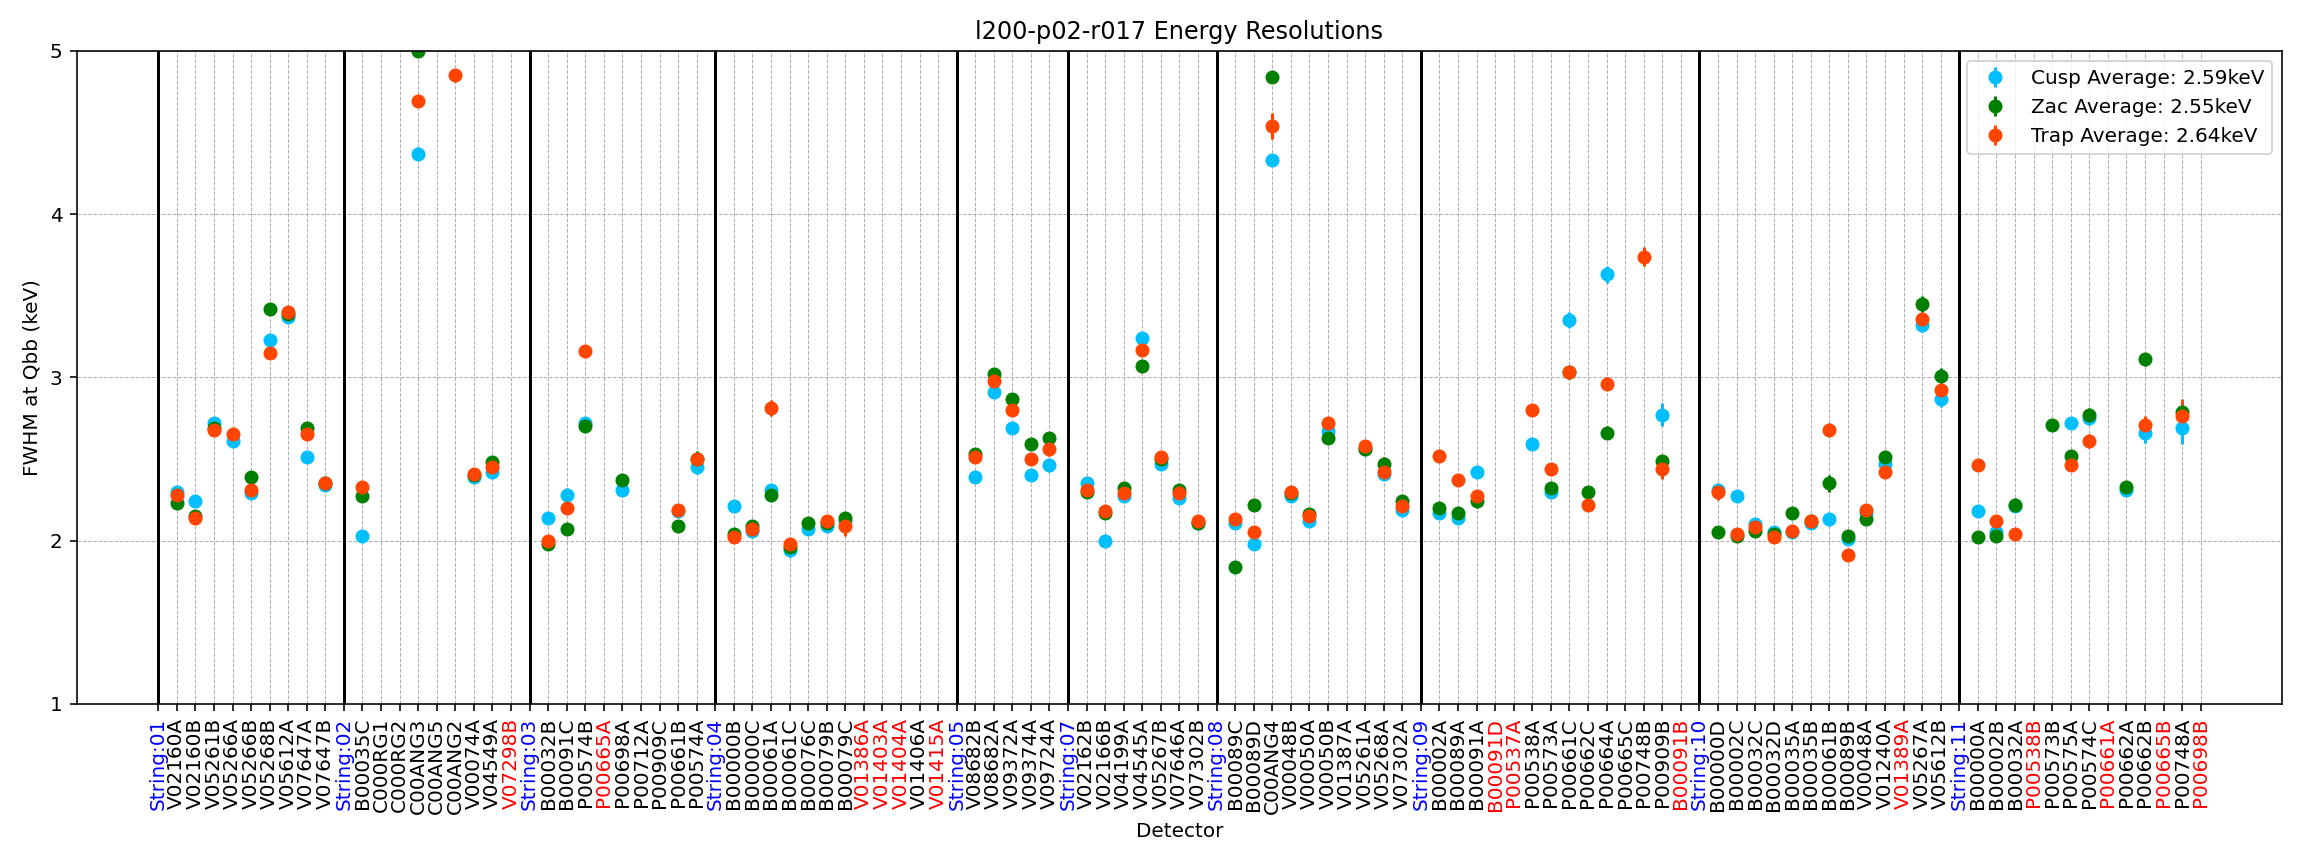
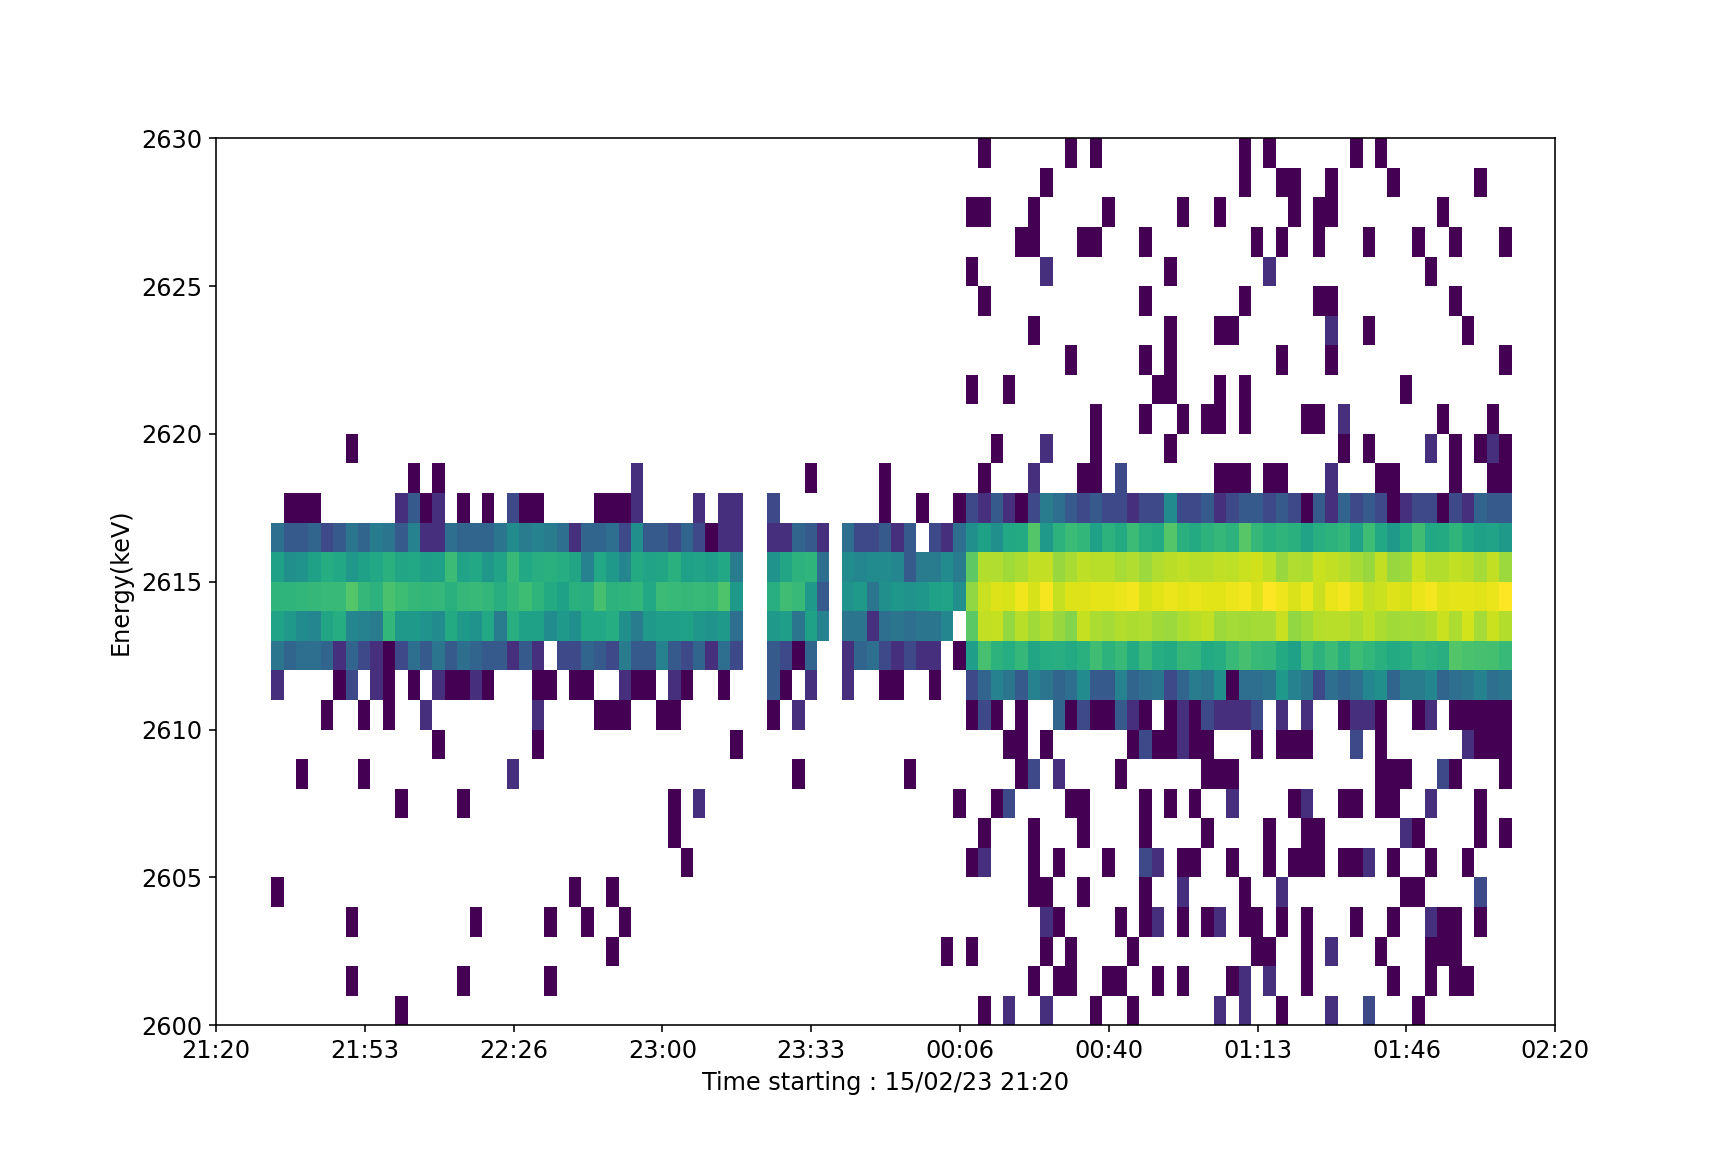

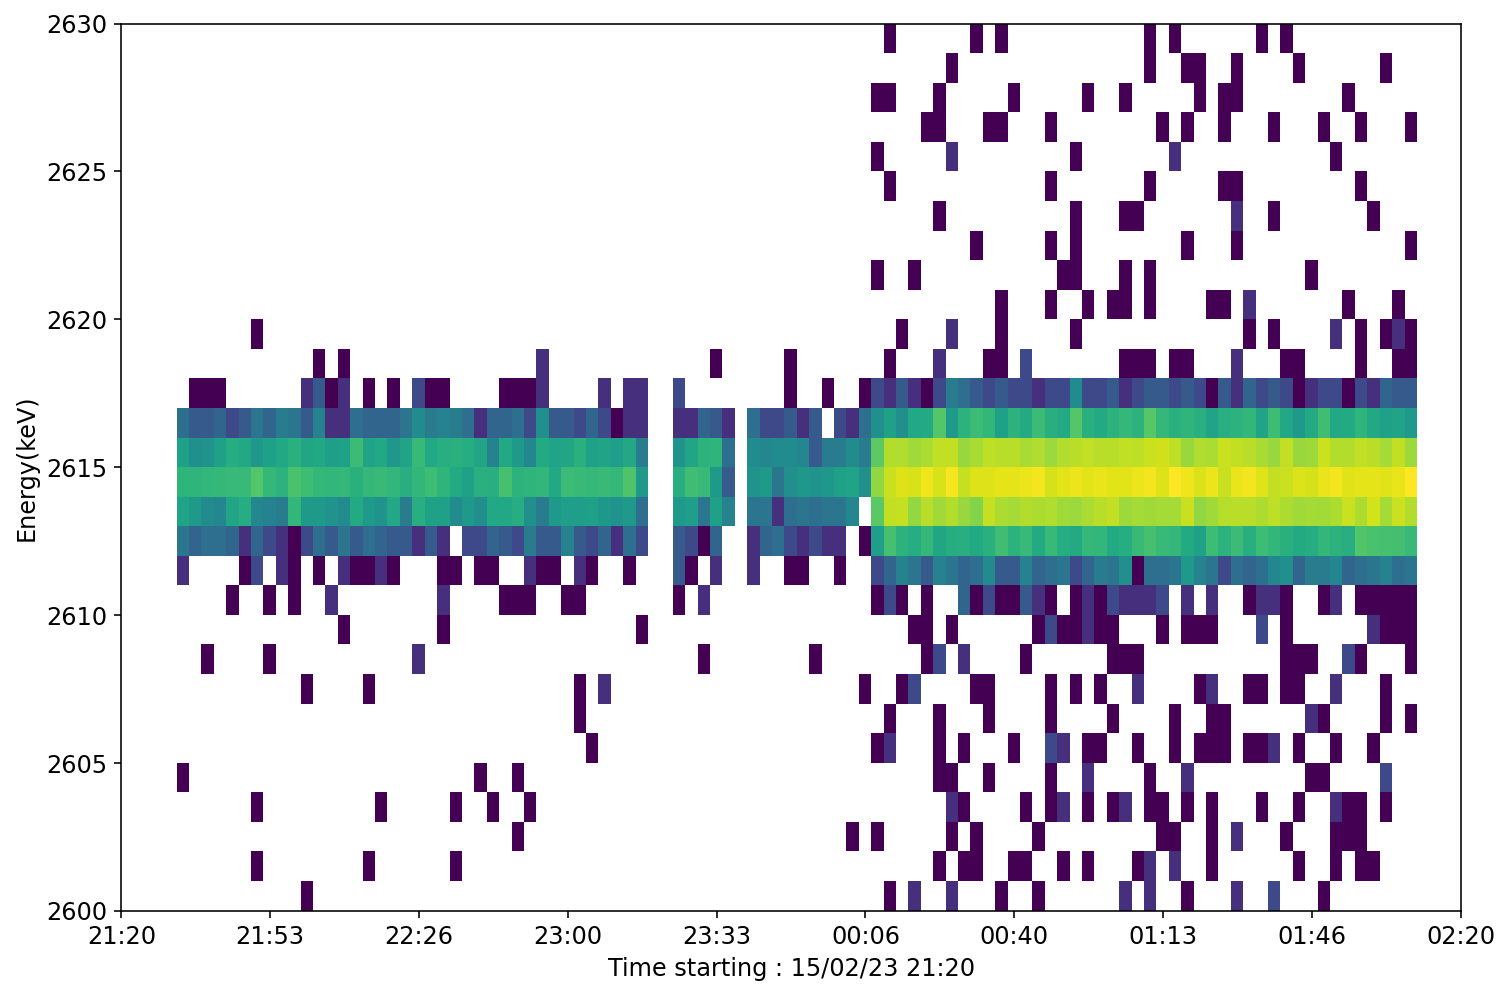

In [39]:
pn.Column(pn.Row(run_param, sort_by_param, string_param),
          pn.Row(
              pn.Column(details_param, summary_param,tracking_param),
              pn.Tabs((pn.Column("# Calibration Plots - Details", 
                        monitor.get_RunAndChannel,
                        monitor.view_details)),
                        pn.Column("# Calibration Plots - Summary", 
                        monitor.view_summary),
                        pn.Column("# Calibration Plots - Tracking", 
                        monitor.view_tracking)
                       )
              
                        
                ), width=10000,scroll=True)